# VGG16 Temporal Action recognition

In [40]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from skimage import transform, filter
import sys, pylab, operator, csv
import util
import os
import urllib
import imageio
import beoid

caffe_root = '../'  # this file is expected to be in {caffe_root}/examples
sys.path.insert(0, caffe_root + 'python')

import caffe
from caffe import layers as L
from caffe import params as P

caffe.set_mode_gpu()

import cnn_utils
pylab.rcParams['figure.figsize'] = (6.0, 6.0)

In [41]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [42]:
model_root_path = "/home/will/nets/dual-stream/temporal"
model_name = "kfold1temporal"

deploy_prototxt_path = os.path.join(model_root_path, "deploy.prototxt")
caffemodel_path = os.path.join(model_root_path, model_name + ".caffemodel")


net = caffe.Net(deploy_prototxt_path,
                caffemodel_path,
                caffe.TEST)

# The very last layer in the network (pre loss layer)
topLayerName = 'fc8'
topBlobName = net.top_names[topLayerName][0]
secondTopLayerName = 'relu7'
secondTopBlobName = net.top_names[secondTopLayerName][0]

# This is the layer we'll stop at when excitation backpropping
outputLayerName = 'pool3'

In [43]:
data_root = "/home/will/data/beoid/temporal/u/04_Door2_scan_card-reader_204-225/"
video_name = os.path.basename(data_root[:-1])

start_frame_index = 1
stop_frame_index = start_frame_index + 20
#image_path = os.path.join(data_root, "desk-plug-plug/frame000084.jpg")
#image_path = os.path.join(data_root, "treadmill-press-button/frame000034.jpg")
#image_path = os.path.join(data_root, "printer-press-button/frame000010.jpg")
#image_path = os.path.join(data_root, "push_drawer/frame000057.jpg")
#image_path = os.path.join(data_root, "insert_screwdriver/frame000135.jpg")
image_paths = [os.path.join(data_root, "frame{:06d}.jpg".format(frame_index)) for frame_index in range(start_frame_index, stop_frame_index)]

new_size = (224, 224)
images = [transform.resize(caffe.io.load_image(image_path)[:, :, 0], new_size) for image_path in image_paths]
images = np.array(images)

optical_flow_gif = video_name + ".gif"
imageio.mimsave(optical_flow_gif, images)
from IPython.display import HTML
HTML("<img src=\"{}\" />".format(optical_flow_gif))

/usr/local/lib/python3.5/dist-packages/imageio/core/util.py:78: UserWarning: Lossy conversion from float64 to uint8, range [0, 1]
  dtype_str, out_type.__name__))


In [44]:
images -= images.mean()

In [45]:
eb = cnn_utils.ExcitationBackprop(net, 'fc8', 'fc7', 'pool3')
net.blobs['data'].data[...] = images.reshape(1, 20, *new_size)
out = net.forward(end = topLayerName)

class_count = 34
scores = net.blobs[eb.top_blob_name].data[0].reshape(class_count, -1).max(1).flatten() # pre-softmax scores
class_ids = scores.argsort()[-3:][::-1]

/home/will/src/Caffe-ExcitationBP/excitationBP/util.py:52: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  ax[(i+1)/2, (i+1)%2].imshow(attMap, interpolation = 'bicubic')
/home/will/src/Caffe-ExcitationBP/excitationBP/util.py:53: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  ax[(i+1)/2, (i+1)%2].set_title(tagName[i])
/home/will/src/Caffe-ExcitationBP/excitationBP/util.py:52: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  ax[(i+1)/2, (i+1)%2].imshow(attMap, interpolation = 'bicubic')
/home/will/src/Caffe-ExcitationBP/excitationBP/util.py:53: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  ax[(i+1)/2, (i+1)%2].set_title(tagName[i])
/home/will/src/Caffe-ExcitationBP/excitationBP/util.py:52: VisibleDeprecationWarning: us

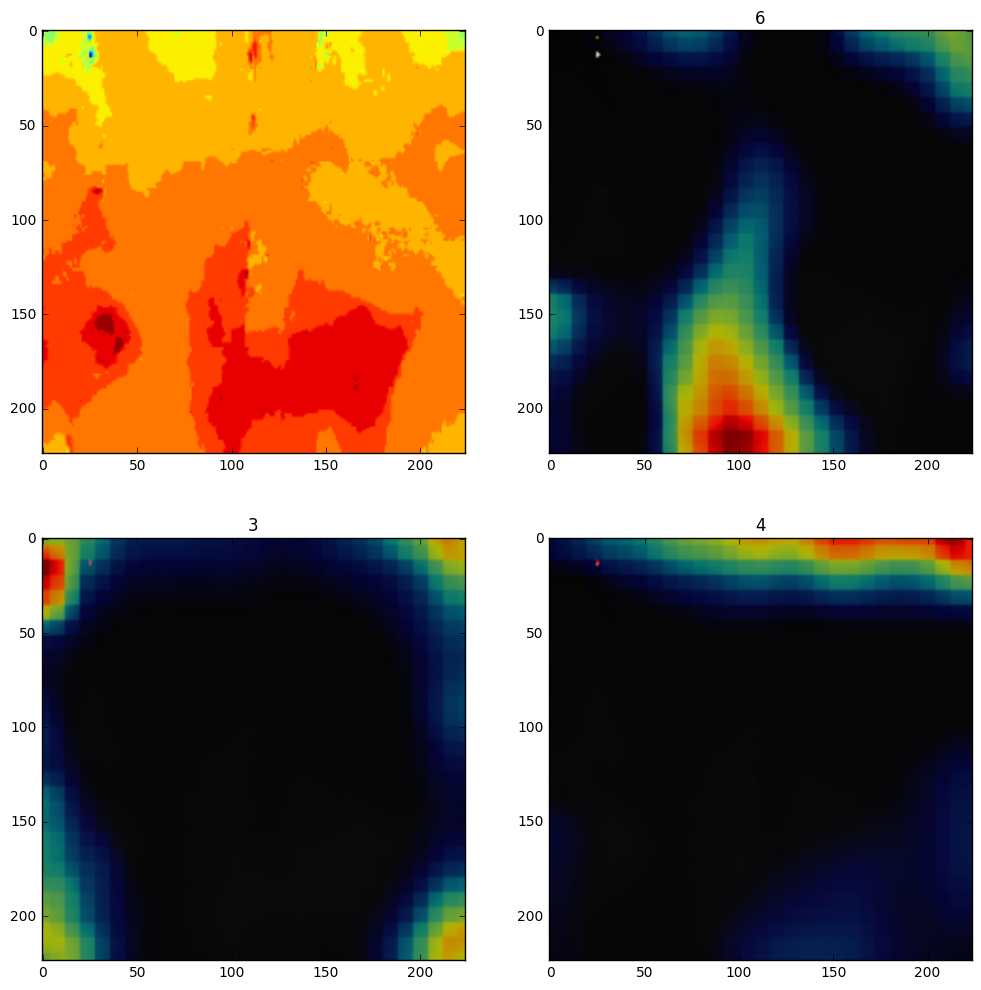

In [46]:
attMaps = []

for class_id in class_ids:
    attMap = eb.backprop(class_id)
    attMaps.append(attMap)
util.showAttMap(images[10], attMaps, class_ids, overlap=True)